In [3]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import StandardScaler
import numpy as np

import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, validation_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [4]:
rice_cammeo_and_osmancik = fetch_ucirepo(id=545)

X = rice_cammeo_and_osmancik.data.features
y = rice_cammeo_and_osmancik.data.targets


print(rice_cammeo_and_osmancik.metadata) 
  

print(rice_cammeo_and_osmancik.variables) 


{'uci_id': 545, 'name': 'Rice (Cammeo and Osmancik)', 'repository_url': 'https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik', 'data_url': 'https://archive.ics.uci.edu/static/public/545/data.csv', 'abstract': "A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice.", 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 3810, 'num_features': 7, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5MW4Z', 'creators': [], 'intro_paper': {'title': 'Classification of Rice Varieties Using Artificial Intelligence Methods', 'authors': 'Ilkay Cinar, M. Koklu', 'published_in': 'International Journal of Intelligent Systems and App

Data DESCR:

A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice.

num_instances: 3810

num_features: 7

class: 2, Cammeo and Osmancik

data_url: https://archive.ics.uci.edu/static/public/545/data.csv

In [5]:

le = LabelEncoder()
y = le.fit_transform(y)


X_selected = np.concatenate((X[:250], X[-250:]), axis=0)
y_selected = np.concatenate((y[:250], y[-250:]))


X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
print('the portion of Cammeo rice is ' + str(round(sum(y_train) / len(y_train) * 100,4)) + '%')
# The dataset is quite balanced.

the portion of Cammeo rice is 49.0%


The selected data(500 samples) is balanced

In [8]:
# make f2 a valid validation
def f2_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 2, pos_label = 0, average = 'binary')

f2 = make_scorer(f2_scorer, greater_is_better=True)

# here for question b: make f05 a valid validation
def f05_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 0.5, pos_label = 0, average = 'binary')

f05 = make_scorer(f05_scorer, greater_is_better = True)

We choose f2 and f0.5 score as optimization objects, because we want to consider both precision and recall, and we also want to obeserve the trade off between them.

F2 score pays recall twice as important as presision, while f0.5 pays precision twice important as recall.

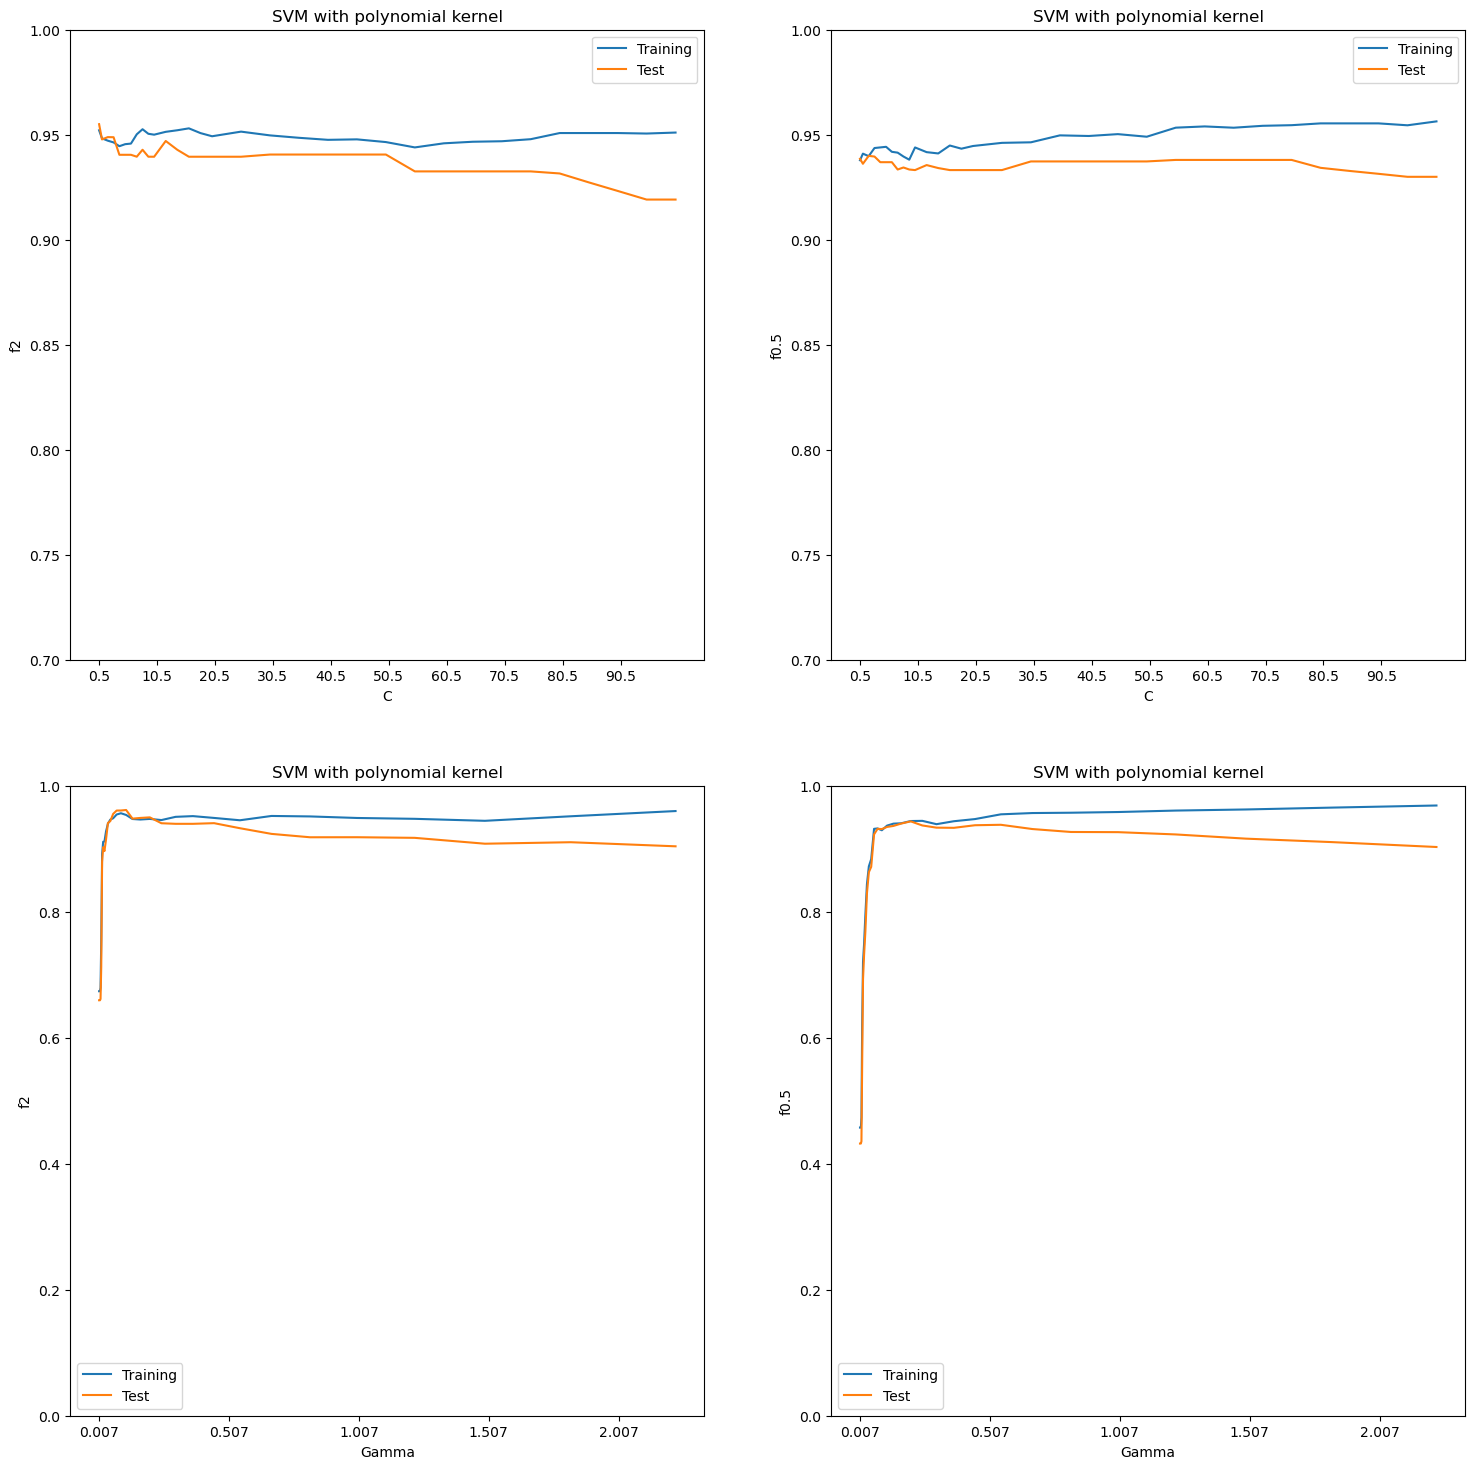

In [9]:
# SVM with polynomial kernel
# for score = f2 and f0.5
# hyperparameters gamma, C 
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#
def plot_poly_curve(gammas = 'auto', Cs = 1, degrees = 3, scoring = f2): # by default
    
    num_splits = 5 # use of k-fold is good
    kfold = KFold(n_splits = 5) # ,random_state = 0) 
    
    if type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', gamma = gammas, degree = degrees)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="C", param_range=Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.7, 1]
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', degree = degrees, C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="gamma", param_range=gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0, 1]
    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = 'Training')
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = 'Test')
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel('f2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title('SVM with polynomial kernel')
    plt.legend()

    
plt.figure(figsize = (18, 18))

Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))

gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(2, 2, 1)
plot_poly_curve(Cs = Cs)
plt.subplot(2, 2, 2)
plot_poly_curve(Cs = Cs, scoring = f05)
plt.subplot(2, 2, 3)
plot_poly_curve(gammas = gammas)
plt.subplot(2, 2, 4)
plot_poly_curve(gammas = gammas, scoring = f05)

plt.show()

For both kernels, the models preform relatively better, when C is small(high degree of regulirazation)

For polynomial kernel, the model preforms bad, when gamma is small(underfitting). The performance gets better with increase of gamma at beginning. But large gamma will result in overfiiting, so at the end, when gamma is large, there is higher score ein traning data but lower score in test data due to overfitting.

But for rbf kernel, there is no distinct and strong influence of gamma.

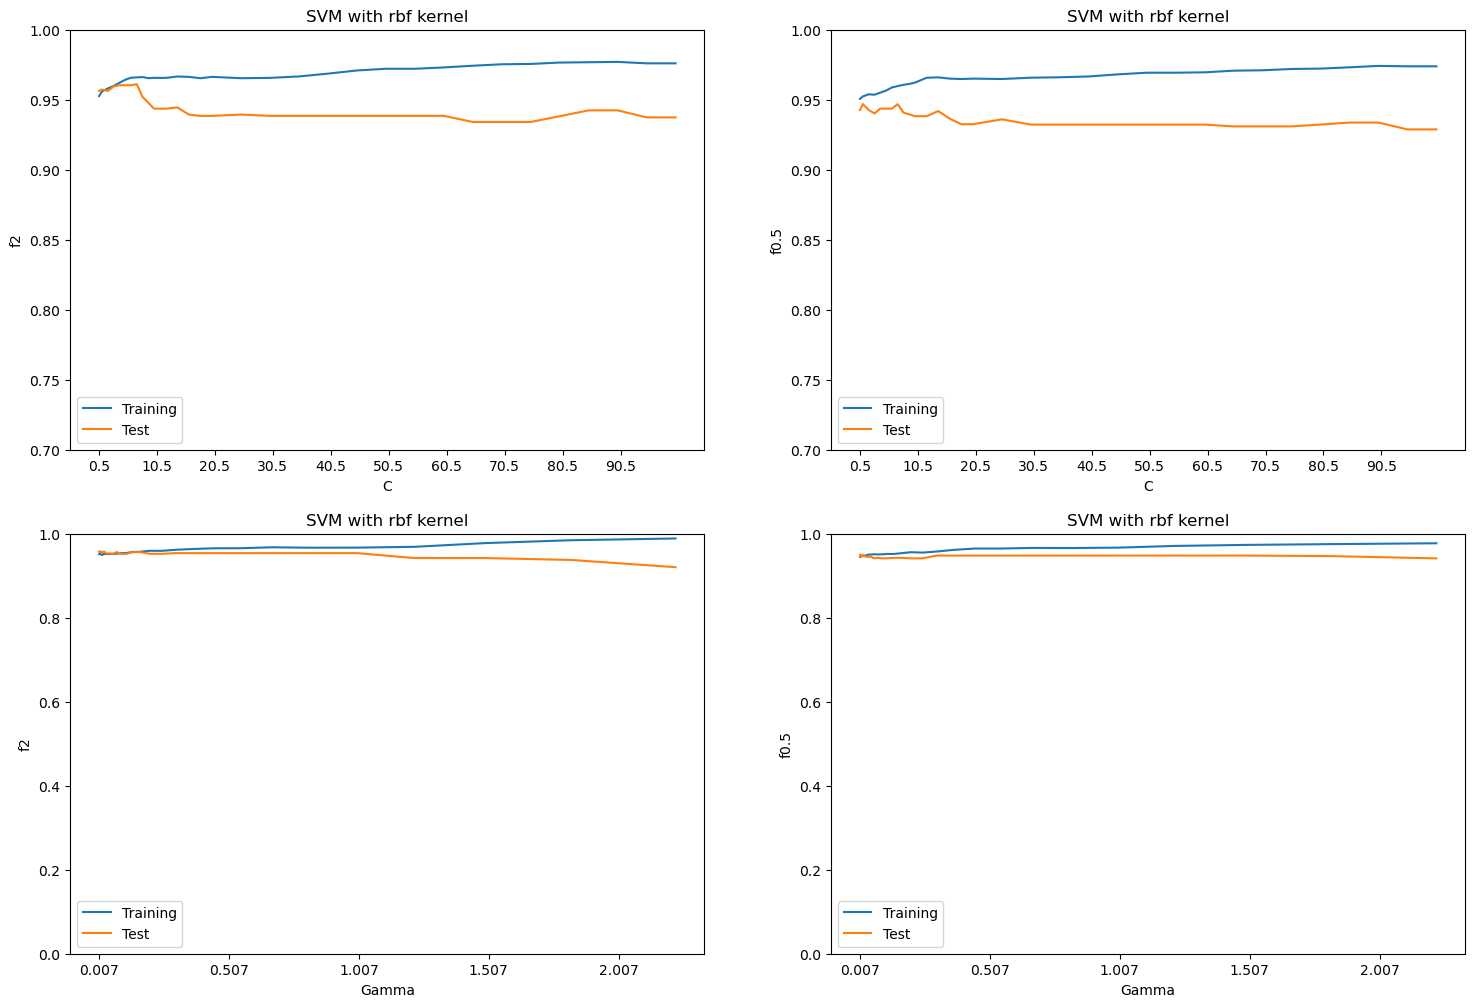

In [11]:
# The two functions can actually be integrated.
def plot_rbf_curve(gammas = 'auto', Cs = 1, scoring = f2): # by default
    
    num_splits = 5 # use of k-fold is good
    kfold = KFold(n_splits = 5) # ,random_state = 0) 
    
    if type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'rbf', gamma = gammas)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="C", param_range=Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.7, 1]
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'rbf', C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  param_name="gamma", param_range=gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0, 1]
    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = 'Training')
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = 'Test')
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel('f2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title('SVM with rbf kernel')
    plt.legend()

    
plt.figure(figsize = (18, 12))

Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))
#gammas = np.arange(0.008, 0.051, 0.002)
gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(2, 2, 1)
plot_rbf_curve(Cs = Cs)
plt.subplot(2, 2, 2)
plot_rbf_curve(Cs = Cs, scoring = f05)
plt.subplot(2, 2, 3)
plot_rbf_curve(gammas = gammas)
plt.subplot(2, 2, 4)
plot_rbf_curve(gammas = gammas, scoring = f05)

plt.show()

In [19]:
start = time.time()

param_grid = {'kernel' : ['poly', 'rbf'],
              'C' : [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100],
              'gamma' : [1/X_train.shape[1], 0.01, 0.1, 1, 10]
              #'degree' : [2, 3, 4, 5, 7, 10]
              }              

scoring = {
    #'Accuracy' : 'accuracy',
           #'Precision' : 'precision', 
           #'recall' : 'recall',
           #'f1' : 'f1', 
           'f2' : f2,
           'f0.5' : f05
           }

svm_ = svm.SVC() #random_state = 0)
CV_svm = GridSearchCV(estimator = svm_, param_grid = param_grid, cv = 5, 
                      scoring = scoring, refit = 'f2')
CV_svm.fit(X_train, y_train)


time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  88.495934009552


In [20]:
# a DataFrame to keep track of the results
params_ = CV_svm.cv_results_['params']
result = {k : [dic[k] for dic in params_] for k in params_[0]}
cln = ['kernel', 'C', 'gamma']

for i in [ 'f0.5', 'f2']:
    result['mean_test_' + i] = CV_svm.cv_results_['mean_test_' + i]
    result['std_test_' + i] = CV_svm.cv_results_['std_test_' + i]
    cln.append('mean_test_' + i)

results = pd.DataFrame(result)
#display(results)

In [21]:
results.loc[results.kernel == 'rbf', 'degree'] = np.nan
results.loc[results.kernel == 'poly', 'degree'] = np.nan

results.drop_duplicates(inplace = True) 
results_sorted2 = results.sort_values('mean_test_f2', ascending = False)
display(results_sorted2.loc[:,cln].head(10))
#display(results_sorted2.tail(10))

,kernel,C,gamma,mean_test_f0.5,mean_test_f2
44,poly,1.000,0.100000,0.939097,0.962229
6,poly,0.001,1.000000,0.939097,0.962229
20,poly,0.100,0.142857,0.928953,0.959497
62,poly,50.000,0.010000,0.910411,0.957758
33,rbf,0.500,0.010000,0.947080,0.957213
43,rbf,1.000,0.010000,0.947080,0.957213
15,rbf,0.010,0.100000,0.917638,0.956661
34,poly,0.500,0.100000,0.927810,0.955566
55,rbf,10.000,0.100000,0.936568,0.954453
30,poly,0.500,0.142857,0.935999,0.954276


For f2 score, we can see that there is no distinct difference in performance between ploy and rgf kernel. 

In [22]:
results.loc[results.kernel == 'rbf', 'degree'] = np.nan
results.loc[results.kernel == 'poly', 'degree'] = np.nan

results.drop_duplicates(inplace = True) 
results_sorted2 = results.sort_values('mean_test_f0.5', ascending = False)
display(results_sorted2.loc[:,cln].head(10))
#display(results_sorted2.tail(10))

,kernel,C,gamma,mean_test_f0.5,mean_test_f2
21,rbf,0.1,0.142857,0.948779,0.950278
33,rbf,0.5,0.010000,0.947080,0.957213
43,rbf,1.0,0.010000,0.947080,0.957213
57,rbf,10.0,1.000000,0.946830,0.923657
53,rbf,10.0,0.010000,0.945891,0.953243
45,rbf,1.0,0.100000,0.944866,0.949222
25,rbf,0.1,0.100000,0.944799,0.949298
35,rbf,0.5,0.100000,0.943677,0.945253
47,rbf,1.0,1.000000,0.943663,0.945313
37,rbf,0.5,1.000000,0.942425,0.941305


For f0.5 score, rbf kernel performs much more better than polynomial kernel. 